In [1]:
import numpy as np
import pandas as pd
from interpret.glassbox import ExplainableBoostingClassifier
from libraries.feature_selection import *
from data_preparation.data_preparation import transform_data
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score
from data_preparation import metrics_eval
from interpret import show
from sklearn.preprocessing import StandardScaler

In [2]:
x_train, y_train = transform_data(pd.read_csv("datasets/in_time.csv"))
x_oot, y_oot = transform_data(pd.read_csv("datasets/out_of_time.csv"))

In [3]:
x_train

,No_dependants,Time_in_address,Time_in_current_job,Credit_cards,Debit_cards,Active_accounts,Active_loans,Num_borrowers,Current_installment,DPD_term_loan_H12,...,incPerSavingsAccountBalance3,incPerSavingsAccountBalance4,incPerSavingsAccountBalance5,incPerSavingsAccountBalance6,incPerSavingsAccountBalance7,incPerSavingsAccountBalance8,incPerSavingsAccountBalance9,incPerSavingsAccountBalance10,incPerSavingsAccountBalance11,incPerSavingsAccountBalance12
Customer_id,,,,,,,,,,,,,,,,,,,,,
33344475,0,3.41,4.13,0,2,2,1,1,813.20,0,...,0.000313,0.000193,0.000174,0.000214,0.000206,0.000156,0.000192,0.000528,0.000752,0.000838
38290809,1,2.28,11.00,0,1,1,1,1,188.29,0,...,0.001061,0.000504,0.001442,0.001123,0.001364,0.000632,0.003352,0.006529,0.003232,0.002179
33178125,1,8.99,1.73,1,2,1,1,1,1008.35,0,...,0.000131,0.000055,0.000097,0.000101,0.000993,0.000238,0.000281,0.000287,0.000301,0.000422
37129367,2,5.55,1.76,0,1,1,1,1,222.44,0,...,0.002117,0.001787,0.000335,0.004537,0.001207,0.000618,0.001100,0.004338,0.027933,0.021410
31904710,1,4.48,8.43,1,1,1,1,1,581.29,0,...,0.000069,0.000108,0.000743,0.000092,0.000089,0.000044,0.000907,0.000566,0.000497,0.000634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31104928,1,1.92,0.63,0,1,1,1,1,651.45,0,...,0.000200,0.000307,0.000423,0.000971,0.000331,0.002004,0.000403,0.008871,0.008346,0.000850
38699158,1,19.89,3.03,0,1,2,1,1,237.41,0,...,0.000062,0.000167,0.002491,0.000730,0.000539,0.000269,0.001277,0.001135,0.001870,0.001657
37435274,3,3.92,3.90,0,2,1,1,2,369.04,0,...,0.000108,0.000601,0.005099,0.007839,0.002114,0.001226,0.000378,0.001596,0.007860,0.002345


In [4]:
columns_to_scale=x_train.columns[x_train.dtypes!=bool]
sc=StandardScaler()
x_train[columns_to_scale]=sc.fit_transform(x_train[columns_to_scale], y_train)
x_oot[columns_to_scale]=sc.transform(x_oot[columns_to_scale])

In [5]:
x_train

,No_dependants,Time_in_address,Time_in_current_job,Credit_cards,Debit_cards,Active_accounts,Active_loans,Num_borrowers,Current_installment,DPD_term_loan_H12,...,incPerSavingsAccountBalance3,incPerSavingsAccountBalance4,incPerSavingsAccountBalance5,incPerSavingsAccountBalance6,incPerSavingsAccountBalance7,incPerSavingsAccountBalance8,incPerSavingsAccountBalance9,incPerSavingsAccountBalance10,incPerSavingsAccountBalance11,incPerSavingsAccountBalance12
Customer_id,,,,,,,,,,,,,,,,,,,,,
33344475,-1.208959,-0.596166,-0.117194,-0.539388,0.657866,1.694919,-0.204544,-0.511618,1.322319,-0.292113,...,-0.075365,-0.075028,-0.073831,-0.073144,-0.074284,-0.072675,-0.074370,-0.072477,-0.073059,-0.070755
38290809,-0.166330,-0.729249,1.216079,-0.539388,-0.714819,-0.478647,-0.204544,-0.511618,-1.129320,-0.292113,...,-0.075261,-0.074985,-0.073652,-0.073015,-0.074122,-0.072607,-0.073932,-0.071628,-0.072713,-0.070563
33178125,-0.166330,0.061005,-0.582966,1.644912,0.657866,-0.478647,-0.204544,-0.511618,2.087929,-0.292113,...,-0.075390,-0.075048,-0.073841,-0.073160,-0.074174,-0.072663,-0.074357,-0.072511,-0.073122,-0.070815
37129367,0.876300,-0.344133,-0.577144,-0.539388,-0.714819,-0.478647,-0.204544,-0.511618,-0.995343,-0.292113,...,-0.075115,-0.074807,-0.073808,-0.072530,-0.074144,-0.072609,-0.074244,-0.071938,-0.069265,-0.067804
31904710,-0.166330,-0.470149,0.717314,1.644912,-0.714819,-0.478647,-0.204544,-0.511618,0.412493,-0.292113,...,-0.075398,-0.075040,-0.073751,-0.073161,-0.074300,-0.072690,-0.074271,-0.072471,-0.073095,-0.070784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31104928,-0.166330,-0.771647,-0.796445,-0.539388,-0.714819,-0.478647,-0.204544,-0.511618,0.687743,-0.292113,...,-0.075380,-0.075012,-0.073796,-0.073036,-0.074266,-0.072412,-0.074340,-0.071296,-0.071999,-0.070753
38699158,-0.166330,1.344726,-0.330673,-0.539388,-0.714819,1.694919,-0.204544,-0.511618,-0.936613,-0.292113,...,-0.075399,-0.075032,-0.073505,-0.073071,-0.074237,-0.072659,-0.074219,-0.072391,-0.072903,-0.070637
37435274,1.918929,-0.536102,-0.161830,-0.539388,0.657866,-0.478647,-0.204544,0.986644,-0.420204,-0.292113,...,-0.075393,-0.074972,-0.073138,-0.072061,-0.074017,-0.072523,-0.074344,-0.072326,-0.072067,-0.070539


In [6]:
model_for_performance = LogisticRegression()
model= ExplainableBoostingClassifier(interactions=0.0)

pipe = Pipeline([
    #('preprocessing' ,full_pipeline_logisitic),
    #('droping not used', FunctionTransformer(lambda x: x.drop(['scale__remainder__customer_id', 'remainder__remainder__application_date', 'remainder__application_status_transform__Application_status', 'remainder__remainder__Application data: employment date (main applicant)'], axis=1))),
    ('Delete features with gini lower than 0.01', GiniSelector(0.01)), 
    ('Smart Correlated Selection', SmartCorrelatedSelection( variables=None,
                                                             method="spearman",
                                                             threshold=0.8,
                                                             missing_values="raise",
                                                             selection_method="model_performance",
                                                             estimator=model_for_performance,).set_output(transform="pandas")),
    #('Cleaning semi-manualy overly correlated featuers',OverCorrelatedDropper(0.6)),
    #('Logistic regression', model)
], verbose = True)
pipe.fit(x_train, y_train)

[Pipeline]  (step 1 of 2) Processing Delete features with gini lower than 0.01, total=  15.6s
[Pipeline]  (step 2 of 2) Processing Smart Correlated Selection, total=  22.7s


Pipeline(steps=[('Delete features with gini lower than 0.01',
                 GiniSelector(threshold=0.01)),
                ('Smart Correlated Selection',
                 SmartCorrelatedSelection(estimator=LogisticRegression(),
                                          method='spearman',
                                          missing_values='raise',
                                          selection_method='model_performance'))],
         verbose=True)

In [7]:
x_transformed=pipe.transform(x_train)

In [8]:
len(x_transformed.columns)

59

In [9]:
corr=x_transformed.corr(method="spearman").values
for i in range(corr.shape[0]):
    for j in range(i):
        if(i!=j):
            if(corr[i,j]>=0.7):
                print(i,j)

In [10]:
model.fit(x_transformed,y_train)

ExplainableBoostingClassifier(interactions=0.0)

In [11]:
importances=[(i,j) for i,j in zip(x_transformed.columns ,model.term_importances())]
variables=[i[0] for i in sorted(importances, key=lambda x: x[1],reverse=True)[:9]]
variables

['DPD_term_loan_H2',
 'Default_flag_H1',
 'Default_flag_H2',
 'DPD_term_loan_H3',
 'incPerSavingsAccountBalance0',
 'Default_flag_H3',
 'Default_flag_H4',
 'DPD_term_loan_H6',
 'incPerCurrentAccountBalance2']

In [12]:
x_selected=x_transformed[variables]
model.fit(x_selected,y_train)

ExplainableBoostingClassifier(interactions=0.0)

In [13]:
pd.concat([x_selected, y_train], axis=1).to_csv("variable.csv")
pd.concat([x_oot[variables], y_oot], axis=1).to_csv("variable_oot.csv")

In [14]:
""" 
('Sequential Feature Selector', SequentialFeatureSelector(model, 
                                                              n_features_to_select=9,
                                                              scoring='roc_auc', 
                                                              cv=5).set_output(transform="pandas")),

"""

' \n(\'Sequential Feature Selector\', SequentialFeatureSelector(model, \n                                                              n_features_to_select=9,\n                                                              scoring=\'roc_auc\', \n                                                              cv=5).set_output(transform="pandas")),\n\n'

In [15]:
y_train_predict=model.predict_proba(x_selected)[:,1]
y_oot_predict=model.predict_proba(x_oot[variables])[:,1]

In [16]:
roc_auc_score(y_train, y_train_predict)

0.820344907857253

In [17]:
roc_auc_score(y_oot, y_oot_predict)

0.7827750715779084

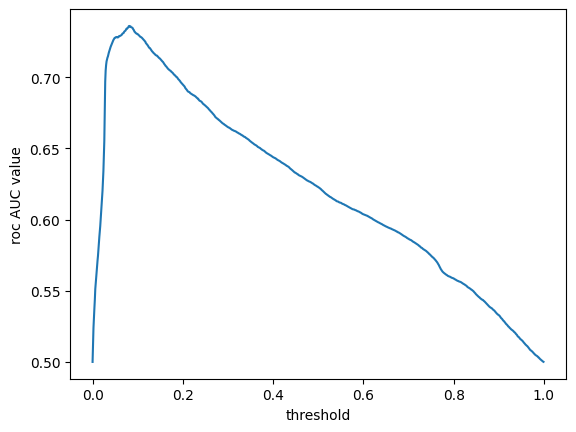

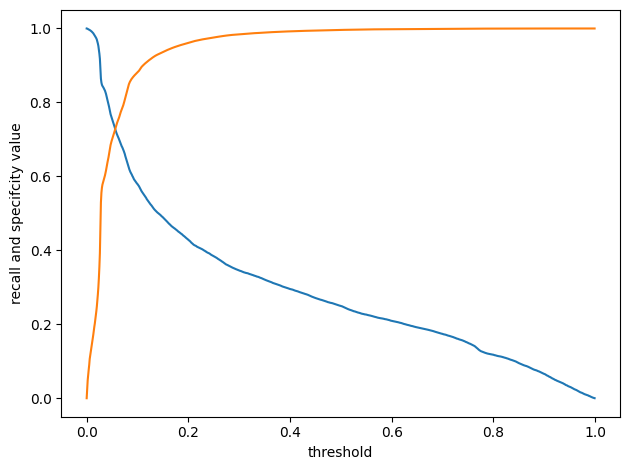

In [18]:
best_threshold=metrics_eval.find_best_threshold(y_train, y_train_predict)

In [19]:
best_threshold

(0.081, 0.7360173201108408)

In [20]:
metrics_eval.evaluate_model(model, x_selected, y_train, x_oot, y_oot,best_threshold[0])

Evaluating model: ExplainableBoostingClassifier


,Model,Dataset,AUC,Accuracy,Precision,Recall,F1-score
0,ExplainableBoostingClassifier,Train,0.820345,0.825571,0.224946,0.632246,0.331830
1,ExplainableBoostingClassifier,Test,0.782775,0.736625,0.205610,0.661629,0.313725


Evaluating model: ExplainableBoostingClassifier


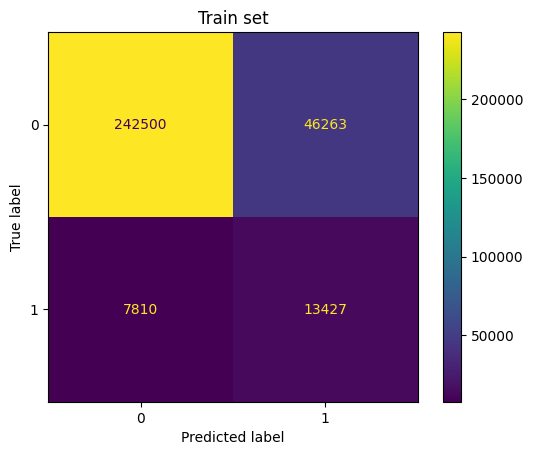

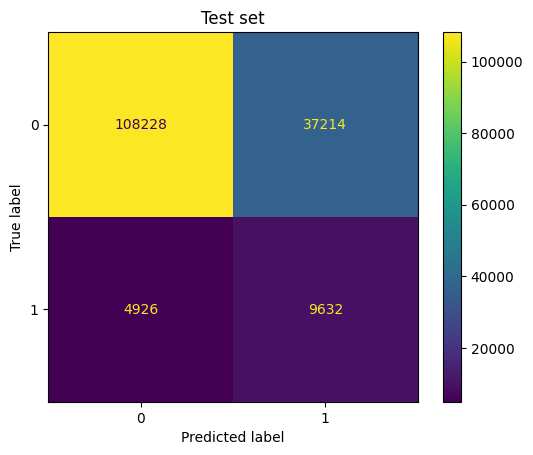

In [21]:
metrics_eval.confusion_matrices(model, x_selected, y_train, x_oot, y_oot,best_threshold[0])

In [22]:
show(model.explain_global())

<!-- http://127.0.0.1:7001/139742906971472/ -->

In [23]:
from interpret.blackbox import PartialDependence

pdp = PartialDependence(model, x_selected)

show(pdp.explain_global(), 0)

<!-- http://127.0.0.1:7001/139742823266320/ -->

In [24]:
from interpret.blackbox import PartialDependence

pdp = PartialDependence(model, x_oot[variables])

show(pdp.explain_global(), 0)

<!-- http://127.0.0.1:7001/139742834944592/ -->

In [25]:
model.term_importances()

array([0.2997312 , 0.17607044, 0.13617545, 0.16021592, 0.39988095,
       0.12665807, 0.13645149, 0.22851321, 0.3876909 ])